#Setup

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

%cd /content/drive/MyDrive/Master Thesis/OcceanPlatformControl

!pip install ipython-autotime > /dev/null
!pip install torchinfo > /dev/null
%load_ext autotime

import numpy as np
import pandas as pd
import scipy
import math
import sys
import platform
import random
from tqdm import tqdm

import torch


from sklearn import model_selection
from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()


SEED = 2022
torch.manual_seed(SEED)
#torch.use_deterministic_algorithms(True)
random.seed(SEED)
np.random.seed(SEED)

if torch.cuda.is_available():
    print('')
    print('\x1b[32mGPU activated.\x1b[0m')
    !nvidia-smi -L
    torch.set_default_tensor_type('torch.cuda.FloatTensor')
else:
    print('')
    print('\x1b[31mNo GPU available.\x1b[0m')

# T4 (0.25TFLOPS)< K80 (1.9TFLOPs) < P100 (5 TFLOPS) < V100 (8 TFLOPS)

print('')
print('Python Version:', platform.python_version())
print('Torch Version:', torch.__version__)
print('')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/Master Thesis/OcceanPlatformControl

GPU activated.
GPU 0: Tesla P100-PCIE-16GB (UUID: GPU-37f185fc-d445-582a-0a31-bed7a19c268f)

Python Version: 3.7.13
Torch Version: 1.11.0+cu113

time: 1.46 s (started: 2022-05-25 18:30:45 +00:00)


#Load Data

In [ ]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

def load_data(number_of_missions = 120, number_of_test_missions = 40, scaler=None, data_augmentation=True):
    number_of_inputs = 245 if data_augmentation==False else 245+2
    number_of_outputs = 9 if data_augmentation==False else 1

    x_train = np.zeros((0, number_of_inputs))
    y_train = np.zeros((0, number_of_outputs))
    x_test = np.zeros((0, number_of_inputs))
    y_test = np.zeros((0, number_of_outputs))

    permutation = np.random.permutation(number_of_missions)

    if data_augmentation:


    missions = list(range(number_of_missions))
    missions.remove(108)
    for i in tqdm(missions):
        with open(f'data/value_function_learning/mission_{i}/x_mission.npy', 'rb') as f:
            x = np.load(f)
        with open(f'data/value_function_learning/mission_{i}/y_mission.npy', 'rb') as f:
            y = np.load(f)

        if data_augmentation:
            dx, dy = np.meshgrid(np.linspace(-1, 1, 3), np.linspace(-1, 1, 3))
            stack = np.stack((dx.flatten(), dy.flatten()), axis=1)
            repeat = np.repeat(stack, repeats=x.shape[0], axis=0)
            x = np.repeat(x, repeats=9, axis=0)
            x = np.concatenate((repeat, x), axis=1)
            y = np.reshape(y, (-1,1))
        
        if i in permutation[:number_of_test_missions]:
            x_test = np.append(x_test, x, axis=0)
            y_test = np.append(y_test, y, axis=0)
        else:
            x_train = np.append(x_train, x, axis=0)
            y_train = np.append(y_train, y, axis=0)

    # Scaling
    if scaler is not None:
        scaler.fit(np.concatenate((x_train, x_test), axis=0))
        x_train = scaler.transform(x_train)
        x_test = scaler.transform(x_test)

    print('')
    print(f'Train: {x_train.shape}, {y_train.shape}')
    print(f'Test:  {x_test.shape},  {y_test.shape}')

    # Convert to Tensors
    x_train = torch.tensor(x_train, dtype=torch.float32)
    y_train = torch.tensor(y_train, dtype=torch.float32)
    x_test = torch.tensor(x_test, dtype=torch.float32)
    y_test = torch.tensor(y_test, dtype=torch.float32)

    return x_train, y_train, x_test, y_test

x_train, y_train, x_test, y_test = load_data(scaler=None) # scaler = StandardScaler(with_mean=True, with_std=True), scaler = MinMaxScaler(feature_range=(-1,1))

100%|██████████| 119/119 [00:09<00:00, 13.05it/s]



Train: (411084, 247), (411084, 1)
Test:  (204570, 247),  (204570, 1)
time: 12.1 s (started: 2022-05-25 18:32:16 +00:00)


#Network

In [ ]:
import torch
import torch.nn as nn
from torchinfo import summary

class Model(nn.Module):
    def __init__(self, cnn_config = [[32, 3, 2, 0], [16, 3, 2, 0]], dense_units = [10], dropout=0.5, input_size=x_train.shape[1], output_size = y_train.shape[1]):
        super(Model, self).__init__()

        self.relu = nn.ReLU()
        self.dropout = torch.nn.Dropout(p=dropout, inplace=False)
        self.decay_parameters = []
        self.no_decay_parameters = []

        # Create CNN Layers
        self.cnn_layers = nn.ModuleList()
        for i, cnn in enumerate(cnn_config):
            in_channels = 1 if i == 0 else cnn_config[i-1][0]
            # CNN
            self.cnn_layers.append( nn.Conv2d(in_channels=in_channels, out_channels=cnn[0], kernel_size=cnn[1], stride=cnn[2], padding=cnn[3]) )
            self.no_decay_parameters.append( self.cnn_layers[-1].weight )
            self.no_decay_parameters.append( self.cnn_layers[-1].bias )
            # Batch Normalization
            self.cnn_layers.append( nn.BatchNorm2d(num_features=cnn[0]) )
            self.no_decay_parameters.append( self.cnn_layers[-1].weight )
            self.no_decay_parameters.append( self.cnn_layers[-1].bias )
            # Activation Function
            if i+1 != len(cnn_config):
                self.cnn_layers.append( self.relu )
            # Dropout Layer
            self.cnn_layers.append( self.dropout )

        # Create Dense Layers
        self.dense_layers = nn.ModuleList()
        dense_units.append(output_size)
        for i, units in enumerate(dense_units):
            in_features = cnn_config[-1][0]*9+(input_size-15*15) if i == 0 else dense_units[i-1]
            # Dense Layer
            self.dense_layers.append( nn.Linear(in_features=in_features, out_features=units) )

            # Activation Function
            if i+1 == len(dense_units):
                self.decay_parameters.append( self.dense_layers[-1].weight )
                self.decay_parameters.append( self.dense_layers[-1].bias )
                self.dense_layers[-1].weight.data.fill_(0)
                self.dense_layers[-1].bias.data.fill_(0)
            else:
                self.no_decay_parameters.append( self.dense_layers[-1].weight )
                self.no_decay_parameters.append( self.dense_layers[-1].bias )
                self.dense_layers.append( self.relu )
            # Dropout Layer
            self.dense_layers.append( self.dropout )

        print(self.cnn_layers)
        print(self.dense_layers)

        #print(self.decay_parameters)
        #print(self.no_decay_parameters)

    def forward(self, input):
        batch_size = input.shape[0]
        # Input Modification

        # CNN Layers
        ttr_map = torch.reshape(input[:, -15*15:], (batch_size, 1, 15, 15))
        for i, layer in enumerate(self.cnn_layers):
            ttr_map = layer(ttr_map)

        # Dense Layers
        true_currents = torch.reshape(input[:, :-15*15], (batch_size, -1))
        ttr_map = torch.flatten(ttr_map, start_dim=1)
        fc = torch.cat((true_currents, ttr_map), axis=1)
        for i, layer in enumerate(self.dense_layers):
            fc = layer(fc)  

        return fc

model = Model()

test_input = torch.unsqueeze(x_train[0], 0)
print(f'x_train:   {test_input.shape}')
print(f'model_out: {model(test_input).shape}')

summary(model, input_size=(1, x_train.shape[1]))

ModuleList(
  (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(2, 2))
  (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU()
  (3): Dropout(p=0.5, inplace=False)
  (4): Conv2d(32, 16, kernel_size=(3, 3), stride=(2, 2))
  (5): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (6): Dropout(p=0.5, inplace=False)
)
ModuleList(
  (0): Linear(in_features=166, out_features=10, bias=True)
  (1): ReLU()
  (2): Dropout(p=0.5, inplace=False)
  (3): Linear(in_features=10, out_features=1, bias=True)
  (4): Dropout(p=0.5, inplace=False)
)
x_train:   torch.Size([1, 247])
model_out: torch.Size([1, 1])


Layer (type:depth-idx)                   Output Shape              Param #
Model                                    --                        --
├─ModuleList: 1-1                        --                        --
├─ModuleList: 1-2                        --                        --
├─ModuleList: 1-1                        --                        --
│    └─Conv2d: 2-1                       [1, 32, 7, 7]             320
│    └─BatchNorm2d: 2-2                  [1, 32, 7, 7]             64
├─ReLU: 1-3                              [1, 32, 7, 7]             --
├─Dropout: 1-4                           [1, 32, 7, 7]             --
├─ModuleList: 1-1                        --                        --
│    └─Conv2d: 2-3                       [1, 16, 3, 3]             4,624
│    └─BatchNorm2d: 2-4                  [1, 16, 3, 3]             32
├─Dropout: 1-5                           [1, 16, 3, 3]             --
├─ModuleList: 1-2                        --                        --
│    └─Line

time: 211 ms (started: 2022-05-25 18:47:11 +00:00)


#Train

100%|██████████| 119/119 [00:08<00:00, 13.74it/s]



Train: (410670, 247), (410670, 1)
Test:  (204984, 247),  (204984, 1)
ModuleList(
  (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(2, 2))
  (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU()
  (3): Dropout(p=0.3, inplace=False)
  (4): Conv2d(32, 16, kernel_size=(3, 3), stride=(2, 2))
  (5): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (6): Dropout(p=0.3, inplace=False)
)
ModuleList(
  (0): Linear(in_features=166, out_features=64, bias=True)
  (1): ReLU()
  (2): Dropout(p=0.3, inplace=False)
  (3): Linear(in_features=64, out_features=64, bias=True)
  (4): ReLU()
  (5): Dropout(p=0.3, inplace=False)
  (6): Linear(in_features=64, out_features=64, bias=True)
  (7): ReLU()
  (8): Dropout(p=0.3, inplace=False)
  (9): Linear(in_features=64, out_features=1, bias=True)
  (10): Dropout(p=0.3, inplace=False)
)
epoch: 0, train loss: 2233.68, test loss: 1801.67
epoch: 5, train loss: 506.70, test loss: 563.26
epoch:

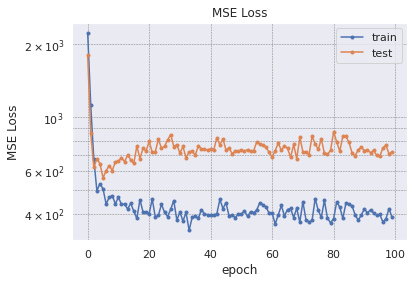

time: 3min 8s (started: 2022-05-25 18:47:21 +00:00)


In [ ]:
x_train, y_train, x_test, y_test = load_data(data_augmentation=True) # scaler = , scaler = MinMaxScaler(feature_range=(-1,1))

n_epochs = 100
batch_size = 5000

train_samples = x_train.shape[0]
validation_samples = x_test.shape[0]

loss_mse_train_epoch = np.zeros(n_epochs)
loss_mse_test_epoch  = np.zeros(n_epochs)
loss_function = nn.MSELoss(reduction='mean')

model = Model(
    cnn_config = [
        [32, 3, 2, 0],
        [16, 3, 2, 0]
    ],
    dense_units = [64, 64, 64],
    dropout=0.3,
    input_size = x_train.shape[1],
    output_size = y_train.shape[1]
)
summary(model, input_size=(1, x_train.shape[1]))

# Adam Default: lr=0.001, betas=(0.9, 0.999), amsgrad=False, weight_decay=0
optimizer = torch.optim.Adam([
    {'params': model.decay_parameters,    'weight_decay': 1e-4, 'lr': 0.005, 'betas': (0.9, 0.999), 'amsgrad':False },
    {'params': model.no_decay_parameters, 'weight_decay': 1e-5, 'lr': 0.001, 'betas': (0.9, 0.999), 'amsgrad':False }
])

for epoch in range(n_epochs):
    # Pre-Train Loss
    model.eval()
    torch.no_grad()
    loss_mse_train_epoch[epoch] = torch.mean(loss_function(model(x_train), y_train)).item()

    # Training
    model.train()
    permutation = torch.randperm(train_samples)
    if True:
        for batch in range(0, train_samples, batch_size):
            # Batch Training
            indices = permutation[batch:batch+batch_size]
            x_batch_x, y_batch = x_train[indices], y_train[indices]
            batch_output = model(x_batch_x)

            LOSS = loss_function(batch_output, y_batch)

            # Optimization
            optimizer.zero_grad()
            LOSS.backward()
            optimizer.step()

    # Validation
    model.eval()
    torch.no_grad()
    loss_mse_test_epoch[epoch] = torch.mean(loss_function(model(x_test), y_test)).item()
    
    # Summary
    if epoch % 5 == 0:
        print(f'epoch: {epoch}, train loss: {loss_mse_train_epoch[epoch]:.2f}, test loss: {loss_mse_test_epoch[epoch]:.2f}')

# Plot Loss History
plt.title('MSE Loss')
plt.semilogy(loss_mse_train_epoch, label='train', marker='.')
plt.semilogy(loss_mse_test_epoch, label='test', marker='.')
plt.ylabel('MSE Loss')
plt.xlabel('epoch')
plt.legend()
plt.grid(True, which="both", linestyle = '--', color = 'grey', linewidth = 0.5)
plt.show()

#Model Analysis

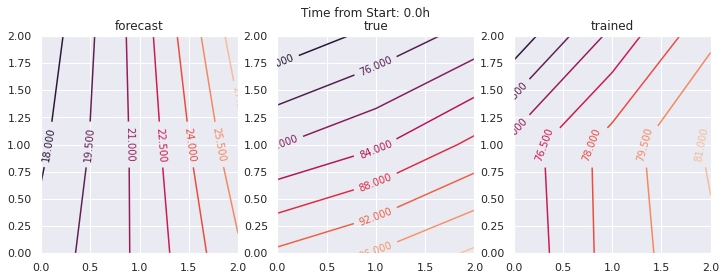

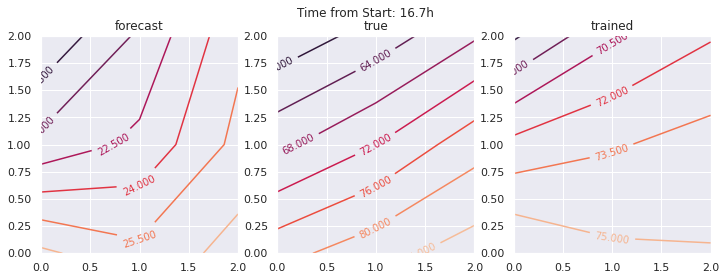

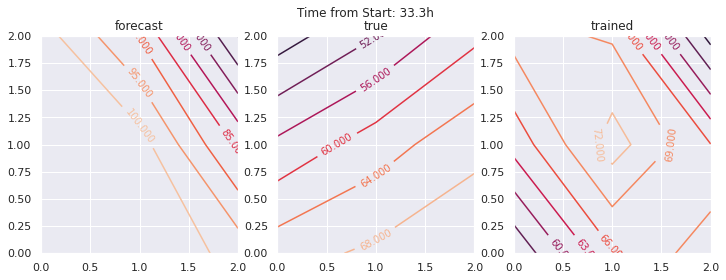

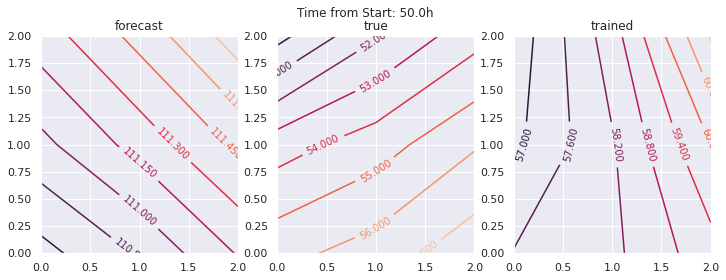

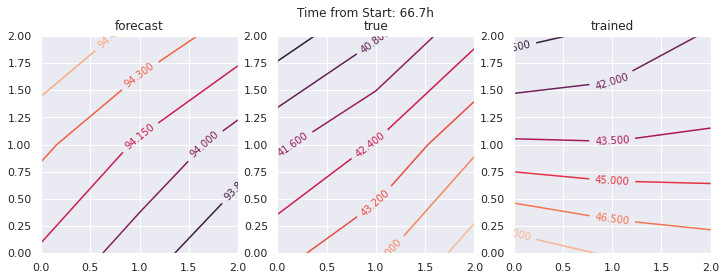

time: 3.59 s (started: 2022-05-25 08:12:29 +00:00)


In [ ]:
def plot_contour(ax, val, title):
    CS = ax.contour(np.arange(val.shape[0]), np.arange(val.shape[1]), val)
    ax.clabel(CS, inline=True, fontsize=10)
    ax.set_title(title)

def plot_forecast_true_trained(x, y, model, time):
    fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(12,4))
    forecast = torch.reshape(x[-15*15:], (15, 15))
    plot_contour(ax1, forecast.cpu().numpy()[7:10,7:10], 'forecast')

    true = forecast[7:10,7:10] + torch.reshape(y, (3, 3))
    plot_contour(ax2, true.cpu().numpy(), 'true')

    after = forecast[7:10, 7:10] + torch.reshape(model(torch.unsqueeze(x,0))[0], (3,3))
    plot_contour(ax3, after.cpu().detach().numpy(), 'trained')

    fig.suptitle(f'Time from Start: {time:.1f}h')
    plt.show()

for i in range(5):
    plot_forecast_true_trained(x_train[100*i], y_train[100*i], model, 100*i/6)